Pip Installs

In [8]:
!pip install matplotlib
!pip install opencv-python
!pip install scikit-image

Imports

In [89]:
import numpy as np
import cv2

from PIL import Image
import math

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from mpl_toolkits.mplot3d import Axes3D

from skimage import io, img_as_float, color

from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.color import label2rgb, rgba2rgb
from skimage.exposure import rescale_intensity
from skimage.morphology import (erosion, dilation, closing, opening, disk, binary_erosion, binary_dilation,
                                area_closing, area_opening, square, remove_small_objects)


Define functions

In [10]:
def uv2xyz(uv,imW,imH):
    tetha = - (uv[:,1] - imH / 2) * np.pi / imH
    phi = (uv[:,0] - imW / 2) * 2 * np.pi / imW
    xyz = np.array([np.sin(phi) * np.cos(tetha),np.cos(tetha) * np.cos(phi),np.sin(tetha)])
    return xyz.T

In [11]:
def cmap2corners(cmap):
    # when corners appear at the image borders, the heatmap can extend to both sides of the image (left and right) 
    # By concatenating 3 times the corner map, we are sure that we detect the maximum once, avoiding repeated corners a
    cmap = cmap/255.
    cmap_ = np.hstack((cmap,cmap,cmap))
    cmap_prob = cmap_.copy()

    th = 0.1
    cmap_[cmap_<th] = 0
    cmap_[cmap_>th] = 1
    label_cmap = label(cmap_)
    regions = regionprops(label_cmap, cmap_prob)
    
    #print(label_cmap)
    
    cor_uv = []
    for props in regions:
        y0, x0 = props.weighted_centroid 
        #cor_uv.append([x0-pano_W,y0])
        if x0 > (pano_W-1) and x0 < (pano_W*2+1):
            cor_uv.append([x0-pano_W,y0])

    cor_uv = np.array(cor_uv)
    #order from left to right
    sorted_cor_uv = sorted(cor_uv, key=lambda x: x[0])
    sorted_cor_uv = np.array([arr.tolist() for arr in sorted_cor_uv])

    return sorted_cor_uv

In [12]:
def separate_regions(map):
    print(map.shape)
    print(type(map))
    map_ = color.rgb2gray(map)
    thresh = threshold_otsu(map_)
    #print(thresh)

    element = np.array([[0,1,0],
                        [1,1,1],
                        [0,1,0]])

    bw = closing(map_ > thresh, element)

    #print(bw)

    cleared = clear_border(bw)

    #print(cleared)

    label_image  = label(bw, background=0)

    image_label_overlay = label2rgb(label_image, image=map_, bg_label=0)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image_label_overlay)
    for region in regionprops(label_image):
        # take regions with large enough areas
        
        if region.area >= 100:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                    fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [13]:
def getWalls(map):
    cmap_ = map/255.
    #cmap_ = np.hstack((emap,emap))
    #cmap_ = emap
    thresh = threshold_otsu(cmap_)
    #print(thresh)

    element = np.array([[0,1,0],
                        [1,1,1],
                        [0,1,0]])

    bw = closing(cmap_ > thresh, element)
    inversbw = abs(1-bw)

    #print(bw)

    cleared = clear_border(inversbw)

    #print(cleared)

    label_image  = label(inversbw, background=0)
    dilated = label_image


    for i in range(15):
        dilated = dilation(dilated, element)
    
    print(np.unique(dilated))

    heigth = len(dilated)
    width = len(dilated[0])
    wallL = dilated[int(heigth/2)][0]
    wallR = dilated[int(heigth/2)][int(width - 1)]
    dilated[dilated == wallL] = wallR
    ceilC = dilated[0][int(width/2)]
    floorC = dilated[heigth-1][int(width/2)]
    uniqueColors = np.unique(dilated)    
    walls = uniqueColors[uniqueColors != 0]
    walls = walls[walls != floorC]
    walls = walls[walls != ceilC]

    wall_info = {
        'ceil' : ceilC,
        'floor' : floorC,
        'walls' : walls
    }
    return dilated, wall_info

In [14]:
def getMergedImage(segments, walls):
    # Convert the images to float and normalize their intensities
    image1_float = rescale_intensity(img_as_float(segments))
    image2_float = rescale_intensity(color.gray2rgb(img_as_float(walls)))

    mask_bool = color.rgb2gray(segments).astype(bool)

    # Combine the images using the mask
    combined_image = image2_float.copy()
    combined_image[mask_bool] = 1.0 * image1_float[mask_bool]

    merged_image = 0.5 * combined_image + 0.5 * img/255
    return combined_image, merged_image

Get images

In [15]:
# load image
img_path = "/home/raimon/Documents/SUSP_CFL/test/RGB/"
img_name = "pano_0dc10e0b094425ff7806d1b922c5ec98.jpg"
img = Image.open(img_path+img_name)
img = np.array(img)
pano_H = img.shape[0]
pano_W = img.shape[1]
print(img.shape)
newsize = (pano_W, pano_H)

# load corner map
cmap_path = "/home/raimon/Documents/SUSP_CFL/test/CM_test/"
cmap_name = "pano_0dc10e0b094425ff7806d1b922c5ec98_cmap.jpg"
cmap = Image.open(cmap_path+cmap_name)
cmap = cmap.resize(newsize)
cmap = np.array(cmap)
print(cmap.shape)

# load edge map
emap_path = "/home/raimon/Documents/SUSP_CFL/test/EM_test/"
emap_name = "pano_0dc10e0b094425ff7806d1b922c5ec98_emap.jpg"
emap = Image.open(emap_path+emap_name)
emap = emap.resize(newsize)
emap = np.array(emap)
print(emap.shape)

# load edge map
smap_path = "/home/raimon/Documents/Panoramic-BlitzNet/Results/PanoBlitznet/"
smap_name = "pano_0dc10e0b094425ff7806d1b922c5ec98_segmentation_raw.png"
smap = Image.open(smap_path+smap_name)
smap = np.array(smap)
print(smap.shape)

(512, 1024, 3)
(512, 1024)
(512, 1024)
(512, 1024, 3)


In [16]:
# get 2D corners from corner map
cor_uv = cmap2corners(cmap)
print(cor_uv)
# get image with walls
walls_image, walls_info = getWalls(emap)
print(walls_info)
merged_image, merged_image_total = getMergedImage(smap, walls_image)

[[ 93.72777788 328.68491004]
 [ 95.86758934 210.49791212]
 [468.89742787 320.07255723]
 [470.16094322 227.46718951]
 [650.80755558 319.10503888]
 [651.2936724  222.07998312]
 [901.31109338 217.34079283]
 [901.941439   319.10804206]]
[0 1 2 3 4 5 6 7]
{'ceil': 1, 'floor': 7, 'walls': array([2, 4, 5, 6])}


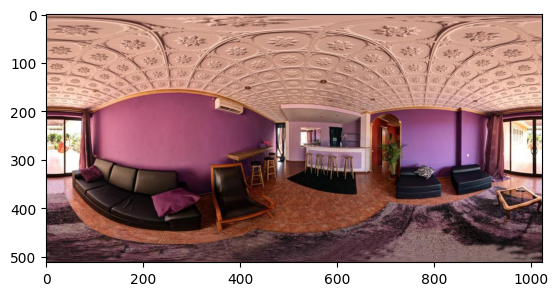

In [17]:
plt.imshow(img)
plt.show()

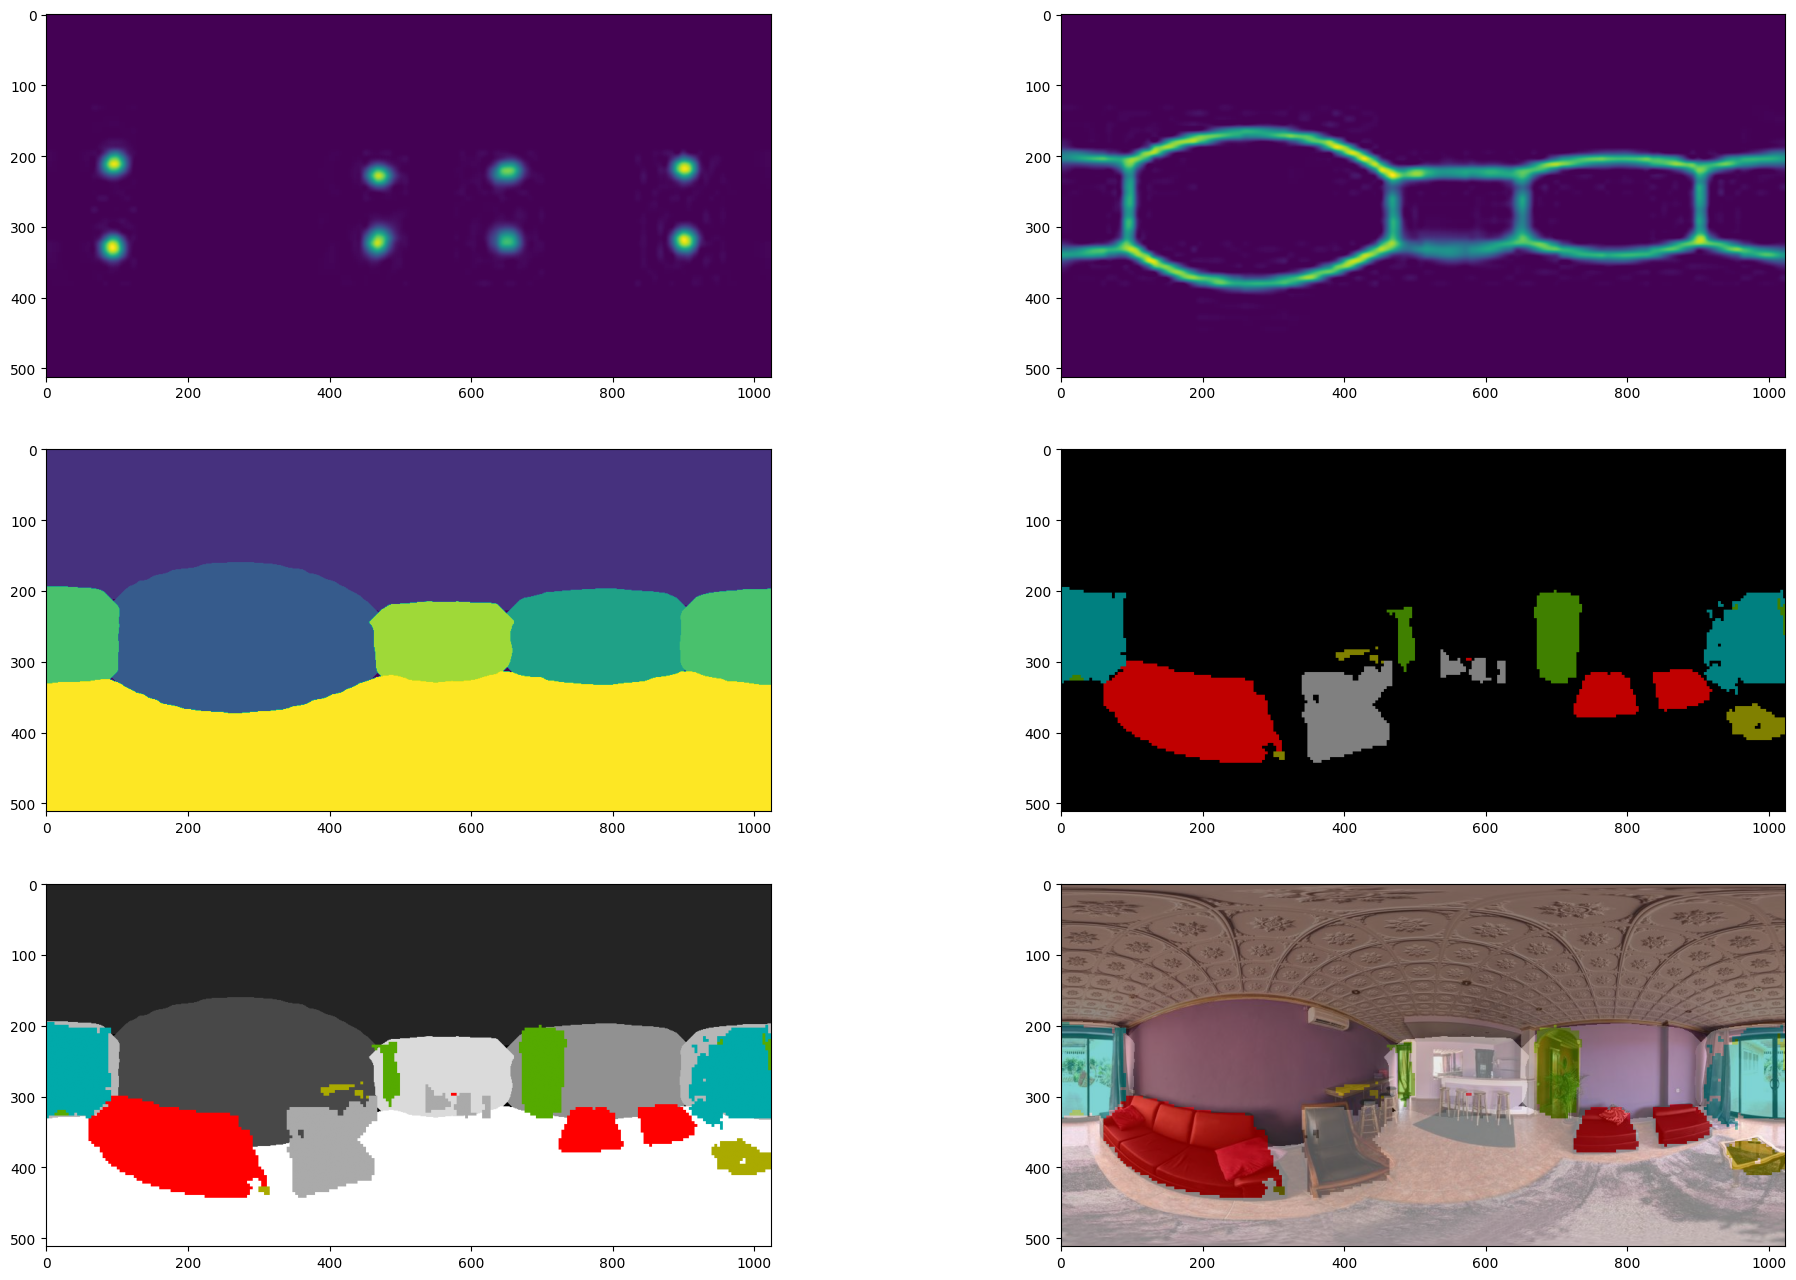

In [18]:
# show corner map and image with 2D corners
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(24,16))

plt.sca(axs[0][0])
plt.imshow(cmap)

plt.sca(axs[0][1]) 
plt.imshow(emap)

plt.sca(axs[1][0]) 
plt.imshow(walls_image)

plt.sca(axs[1][1]) 
plt.imshow(smap)

plt.sca(axs[2][0]) 
plt.imshow(merged_image)

plt.sca(axs[2][1]) 
plt.imshow(merged_image_total)

plt.show()

Define DB

In [19]:
Items = {
    0:  {'color': [0,0,0]       ,'name': 'none'     , 'type' : 0 },
    1:  {'color': [128,0,0]     ,'name': 'bed'      , 'type' : 2 },
    2:  {'color': [0,128,0]     ,'name': 'painting' , 'type' : 1 },
    3:  {'color': [128,128,0]   ,'name': 'table'    , 'type' : 3 },
    4:  {'color': [0,0,128]     ,'name': 'mirror'   , 'type' : 1 },
    5:  {'color': [128,0,128]   ,'name': 'window'   , 'type' : 1 },
    6:  {'color': [0,128,128]   ,'name': 'curtain'  , 'type' : 1 },
    7:  {'color': [128,128,128] ,'name': 'chair'    , 'type' : 3 },
    8:  {'color': [64,0,0]      ,'name': 'light'    , 'type' : 4 },
    9:  {'color': [192,0,0]     ,'name': 'sofa'     , 'type' : 3 },
    10: {'color': [64,128,0]    ,'name': 'door'     , 'type' : 1 },
    11: {'color': [192,128,0]   ,'name': 'cabinet'  , 'type' : 2 },
    12: {'color': [64,0,128]    ,'name': 'bedside'  , 'type' : 3 },
    13: {'color': [192,0,128]   ,'name': 'tv'       , 'type' : 4 },
    14: {'color': [64,128,128]  ,'name': 'none'     , 'shelf' : 2 }   
}

Types = { 
    0: {'name' : 'none'             , 'items' : [0]},
    1: {'name' : 'wall_item'        , 'items' : [2, 4, 5, 6, 10]},
    2: {'name' : 'wall_floor_item'  , 'items' : [1, 11, 14]},
    3: {'name' : 'floor_item'       , 'items' : [3, 7, 9, 12]},
    4: {'name' : 'others'           , 'items' : [8, 13]}
}


In [20]:
def get_keys_from_value(val):
    return [k for k, v in Items.items() if v['color'] == val]

def getItemIdList(smap):
    listColors = np.unique(smap.reshape(-1, smap.shape[2]), axis=0)
    listIds = []
    for i in range(len(listColors)):
        listIds.append(get_keys_from_value(listColors[i].tolist())[0])
    return listIds

In [21]:
list = getItemIdList(smap)
print(list)

[0, 6, 10, 3, 7, 9]


In [22]:
color = [64,128,0]
indices = np.where(np.all(smap == color, axis=-1))

print(len(indices[0]))
print(len(indices[1]))

9568
9568


[(680.0, 190.0), (670.0, 310.0), (1330.0, -7610.0), (70.0, 190.0), (730.0, 190.0), (720.0, 320.0)]
512
1024
[(680.0, 190.0), (670.0, 310.0), (70.0, 190.0), (730.0, 190.0), (720.0, 320.0)]


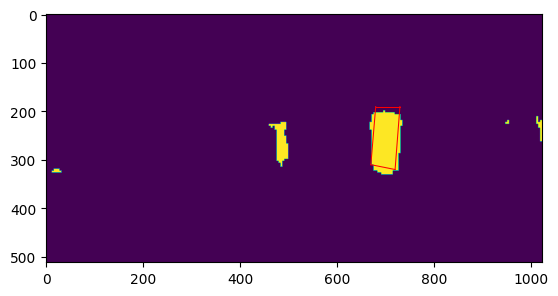

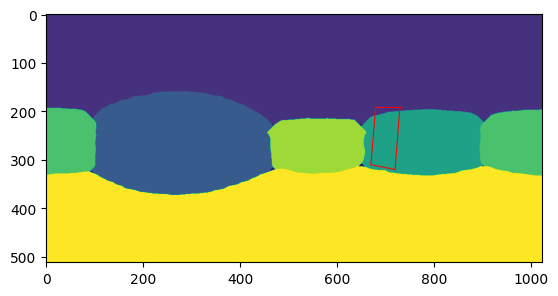

In [23]:
lines =np.array([
    [ 680,   190, 670,  310],
    [ 680,   190, 730,  190],
    [ 670,  310, 720,  320],
    [ 730,  190, 720,  320]
])

points_tmp = np.array([
    [680,   190],
    [670,  310],
    [730,  190],
    [720,  320]
])
lines = np.asarray(lines)

line_params = []
for x1, y1, x2, y2 in lines:
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    line_params.append((m, b))

# Find the point of intersection for each pair of lines using their slope and intercept parameters
points = []
for i in range(4):
    for j in range(i+1, 4):
        m1, b1 = line_params[i]
        m2, b2 = line_params[j]
        x = (b2 - b1) / (m1 - m2)
        y = m1 * x + b1
        points.append((x, y))

print(points)
print(len(walls_image))
print(len(walls_image[0]))
valid_points = []
for point in points:
    x, y = point
    if 0 <= x <= len(walls_image[0]) and 0 <= y <= len(walls_image):
        valid_points.append(point)

print(valid_points)

plt.imshow(np.all(smap == color, axis=-1))
for line in lines:
    plt.plot([line[0], line[2]], [line[1], line[3]], 'r-', linewidth=0.75)
plt.show()

plt.imshow(walls_image)
for line in lines:
    plt.plot([line[0], line[2]], [line[1], line[3]], 'r-', linewidth=0.75)
plt.show()

In [24]:
print(points_tmp)
print(uv2xyz(points_tmp,pano_W,pano_H))

[[680 190]
 [670 310]
 [730 190]
 [720 320]]
[[ 0.78835025  0.47251895  0.39399204]
 [ 0.77973769  0.53496014 -0.32531029]
 [ 0.89424259  0.21236871  0.39399204]
 [ 0.88409759  0.26818807 -0.38268343]]


RANSAC etc

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


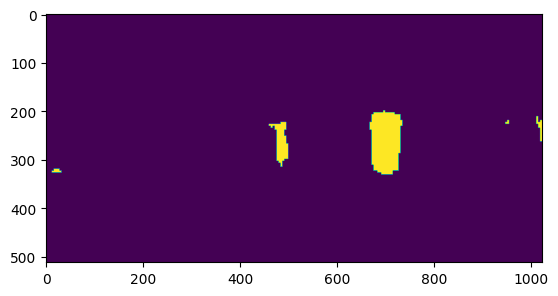

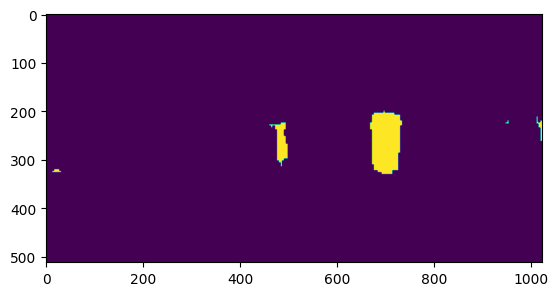

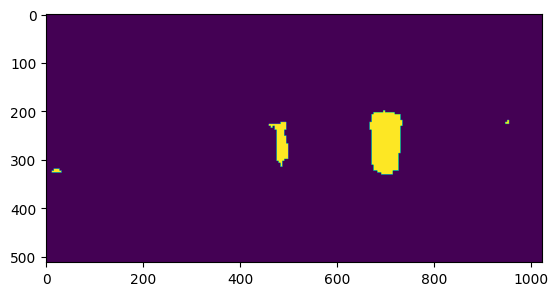

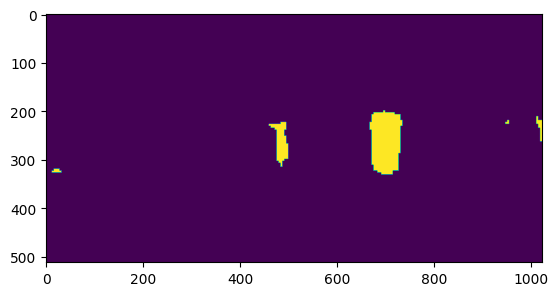

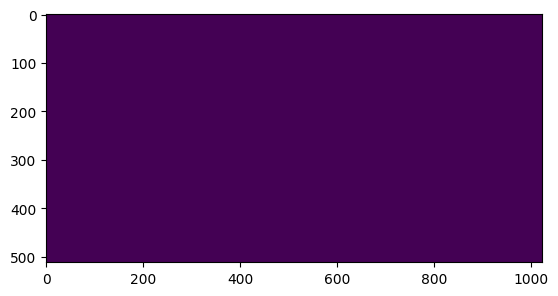

In [25]:

tmp = np.all(smap == color, axis=-1)
int_array = np.uint8(tmp * 255)
#cv2.imshow("Image", int_array)
print(int_array)
plt.imshow(int_array)
plt.show()


element = np.array([[0,1,0],
                    [1,1,1],
                    [0,1,0]])
eroded = erosion(int_array, element)

plt.imshow(eroded)
plt.show()

cleared = clear_border(int_array,)

plt.imshow(cleared)
plt.show()
selem = square(7)
closed = closing(int_array, selem)

plt.imshow(closed)
plt.show()
min_size = 10000
small = remove_small_objects(int_array, min_size=min_size)

plt.imshow(small)
plt.show()

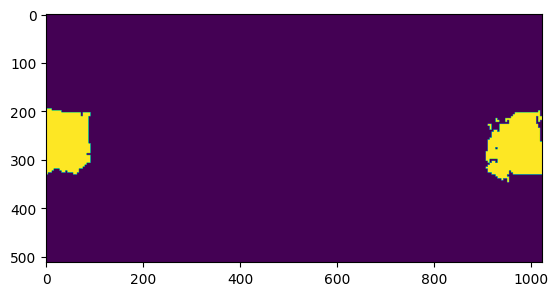

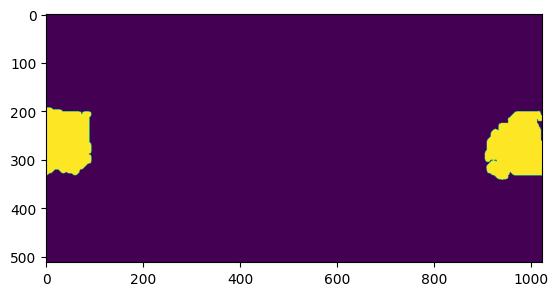

In [26]:
color = [0, 128, 128]
tmp = np.all(smap == color, axis=-1)
int_array = np.uint8(tmp * 255)

threshold = threshold_otsu(int_array)
binary_mask = int_array > threshold

# Define the structuring elements for erosion and dilation
erosion_element = disk(3)
dilation_element = disk(5)

# Remove noise from the binary mask using erosion and dilation
eroded = binary_erosion(binary_mask, erosion_element)
dilated = binary_dilation(eroded, dilation_element)

plt.imshow(int_array)
plt.show()
plt.imshow(dilated)
plt.show()

In [27]:
# Threshold the image to obtain the object mask
#ret, thresh = cv2.threshold(int_array, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
ret, thresh = cv2.threshold( np.uint8(dilated * 255), 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

print(type(int_array))
print(type(dilated))
print(int_array)
print(dilated)

# Optionally apply morphological operations to clean up the mask
kernel = np.ones((3,3), np.uint8)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [28]:
lines = cv2.HoughLinesP(thresh, rho=1, theta=np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)

# Draw the detected lines on the image for visualization
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

In [29]:
# Define the RANSAC parameters
n_iterations = 1000
n_samples = 4
tolerance = 10

# Apply RANSAC to select the best set of lines
best_lines = None
best_inliers = 0
for i in range(n_iterations):
    # Randomly select a set of four lines
    sample = np.random.choice(lines.shape[0], size=n_samples, replace=False)
    sample_lines = lines[sample]

    # Fit the lines to the object mask
    mask = np.zeros(thresh.shape, dtype=np.uint8)
    for line in sample_lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(mask, (x1, y1), (x2, y2), 255, 1)
    inliers = cv2.countNonZero(cv2.bitwise_and(thresh, mask))

    # Check if this is the best set of lines so far
    if inliers > best_inliers:
        best_lines = sample_lines
        best_inliers = inliers

# Draw the best set of lines on the image for visualization


In [30]:
for line in best_lines:
    print(line[0])

[  1  15 918 331]
[   0  141 1023  416]
[   0   40 1023  392]
[   0   60 1022  392]


[ WARN:0@93.073] global loadsave.cpp:244 findDecoder imread_('image.jpg'): can't open/read file: check file path/integrity


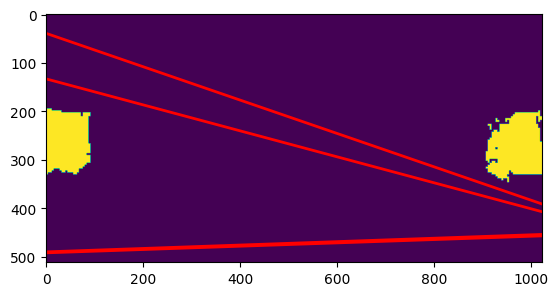

In [ ]:
img = cv2.imread('image.jpg')

# Create a matplotlib figure and axis
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(int_array)
for line in best_lines:
    x1, y1, x2, y2 = line[0]
    ax.plot([x1, x2], [y1, y2], 'r-', linewidth=2)
plt.show()

In [ ]:
# Compute the vanishing points of the lines
vanishing_points = []
for line1 in best_lines:
    for line2 in best_lines:
        if line1 is not line2:
            p1 = np.cross(line1[0], line2[0])
            p1 = p1[:2] / p1[2]
            if np.all(p1 >= 0) and np.all(p1 <= np.array(thresh.shape[::-1])):
                vanishing_points.append(p1)


ValueError: incompatible dimensions for cross product
(dimension must be 2 or 3)

In [ ]:
#separate_regions(smap)
map_ = color.rgb2gray(smap)
print(map_)

AttributeError: 'list' object has no attribute 'rgb2gray'

3D Part

In [31]:
# project pixel coordinates onto the unit sphere
cor_xyz = uv2xyz(cor_uv,pano_W,pano_H)

# separate ceiling and floor corners according to the horizon line (if image is aligned, the horizon line is centered)
ceil_xyz = cor_xyz[cor_xyz[:,2]>0,:]
floor_xyz = cor_xyz[cor_xyz[:,2]<0,:]

In [32]:
print(ceil_xyz)
print(floor_xyz)

[[-0.53340731 -0.79970621  0.27558413]
 [-0.2500292   0.95244212  0.17418212]
 [ 0.73809075  0.64228154  0.20663122]
 [ 0.66454675 -0.7093353   0.2349916 ]]
[[-0.4907199  -0.75705405 -0.43135037]
 [-0.24145908  0.89159181 -0.38309471]
 [ 0.69670643  0.60993045 -0.37760428]
 [ 0.6304531  -0.67818213 -0.37762135]]


In [33]:
# floor plane - assumption: camera at 1.7m
d_floor = 1.7
t_floor = -d_floor/floor_xyz[:,2]
floor_3D = np.expand_dims(t_floor, axis=1) * floor_xyz

In [34]:
# ceiling plane - assumption: ceiling plane and floor plane are parallel
t_ceil = floor_3D[:,0]/ceil_xyz[:,0]
ceil_3D = np.expand_dims(t_ceil, axis=1) * ceil_xyz
d_ceil = np.mean(t_ceil*ceil_xyz[:,2])
ceil_3D[:,2] = d_ceil

In [77]:
def visualizeEdges(floor_3D, ceil_3D):
    # sample points to visualize 3D layout
    n = 80
    print(floor_3D)
    print(type(floor_3D))

    floor_3D = np.vstack((floor_3D, floor_3D[0,:]))
    ceil_3D = np.vstack((ceil_3D, ceil_3D[0,:]))

    floor_structure = np.array([[np.linspace(floor_3D[p,0],floor_3D[p+1,0],n), \
                    np.linspace(floor_3D[p,1],floor_3D[p+1,1],n), \
                    np.linspace(floor_3D[p,2],floor_3D[p+1,2],n)] for p in range(len(floor_3D)-1)])
    ceil_structure = np.array([[np.linspace(ceil_3D[p,0],ceil_3D[p+1,0],n), \
                    np.linspace(ceil_3D[p,1],ceil_3D[p+1,1],n), \
                    np.linspace(ceil_3D[p,2],ceil_3D[p+1,2],n)] for p in range(len(ceil_3D)-1)])
    walls_structure = np.array([[np.linspace(floor_3D[p,0],ceil_3D[p,0],n), \
                    np.linspace(floor_3D[p,1],ceil_3D[p,1],n), \
                    np.linspace(floor_3D[p,2],ceil_3D[p,2],n)] for p in range(len(ceil_3D))])

    # display the 3D layout
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(walls_structure[:,0,:], walls_structure[:,1,:], walls_structure[:,2,:])
    ax.scatter(floor_structure[:,0,:], floor_structure[:,1,:], floor_structure[:,2,:])
    ax.scatter(ceil_structure[:,0,:], ceil_structure[:,1,:], ceil_structure[:,2,:])

    ax._axis3don = False
    plt.show()

In [36]:
def alignFloorCeil(f3D, c3D):
    if len(ceil_xyz) != len(floor_xyz):
        print("error")
        return None, None
    else:
        for i in range(len(f3D)):
            temp_x = (f3D[i][0] + c3D[i][0])/2
            temp_y = (f3D[i][1] + c3D[i][1])/2
            f3D[i] = [temp_x, temp_y, f3D[i][2]]
            c3D[i] = [temp_x, temp_y, c3D[i][2]]
        return f3D, c3D

In [46]:
def getWalls(floor, ceil):
    if len(floor) != len(ceil):
        print("error")
        return None, None
    else:
        floor = np.vstack((floor, floor[0,:]))
        ceil = np.vstack((ceil, ceil[0,:]))
        walls = []
        for i in range(len(floor) - 1):
            walls.append([floor[i], floor[i + 1], ceil[i + 1], ceil[i]])
        return np.array(walls)

In [90]:
standardCeilingHeigh = 2.4
def getNewPoint(P, S, T):
    P = S @ T @ np.append(P, 1)
    return P[:-1]

def rescaleRoom(room):
    floor = room["floor"]
    ceil = room["ceil"]
    walls = room["walls"]
    objects = room["objects"]
    origin_floor = walls[0][0]
    origin_ceil = walls[0][3]
    next_floor = walls[1][0]
    print(origin_floor)
    print(origin_ceil)
    T = np.array([  [1, 0, 0, -origin_floor[0]],
                    [0, 1, 0, -origin_floor[1]],
                    [0, 0, 1, -origin_floor[2]],
                    [0, 0, 0, 1]])
    scale = standardCeilingHeigh/ (origin_ceil[2] -origin_floor[2])
    # Scaling matrix
    S = np.array([[scale, 0, 0, 0],
                [0, scale, 0, 0],
                [0, 0, scale, 0],
                [0, 0, 0, 1]])
    #
    angle = math.atan(next_floor[0]/next_floor[1])

    R = np.array([[math.cos(angle), -math.sin(angle), 0, 0],
                [math.sin(angle), math.cos(angle), 0, 0],
                [0,     0, 1, 0],
                [0,     0, 0, 1]])
    for i in range(len(floor)):
        floor[i] = getNewPoint(floor[i], S, T)
        ceil[i] = getNewPoint(ceil[i], S, T)
        for j in range(4):
            walls[i][j] = getNewPoint(walls[i][j], S, T)
    return getRoom(floor, ceil, walls, objects)
    

In [42]:
def getRoom(floor, ceil, walls, objects):
    room = {
    'ceil' : np.array(floor),
    'floor' : np.array(ceil),
    'walls' : np.array(walls),
    'objects' : np.array(objects)
}
    return room

In [38]:
print(floor_3D)
print(ceil_3D)

[[-1.93398194 -2.98363459 -1.7       ]
 [-1.07148554  3.95647873 -1.7       ]
 [ 3.13661944  2.74594808 -1.7       ]
 [ 2.83821421 -3.05308382 -1.7       ]]
[[-1.93398194 -2.89950541  0.90684267]
 [-1.07148554  4.08163517  0.90684267]
 [ 3.13661944  2.72946484  0.90684267]
 [ 2.83821421 -3.02950176  0.90684267]]


In [85]:
new_floor_3D, new_ceil_3D = alignFloorCeil(floor_3D, ceil_3D)
walls = getWalls(new_floor_3D, new_ceil_3D)
objects = []
room = getRoom(new_floor_3D, new_ceil_3D, walls, objects)

In [86]:
new_room = rescaleRoom(room)

[-1.93398194 -2.94157    -1.7       ]
[-1.93398194 -2.94157     0.90684267]


<class 'numpy.ndarray'>
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.94060716e-01  6.40832869e+00  2.22044605e-16]
 [ 4.66826919e+00  5.22864830e+00  2.22044605e-16]
 [ 4.39354123e+00 -9.18101815e-02  0.00000000e+00]]
[]


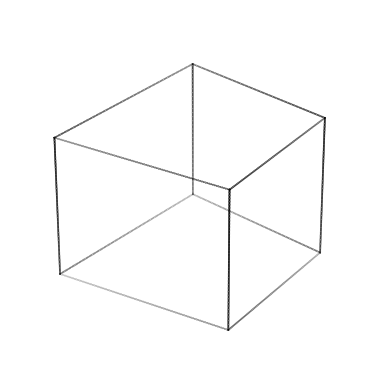

In [87]:
visualizeRoom(new_room)

[[-1.93398194 -2.94157    -1.7       ]
 [-1.07148554  4.01905695 -1.7       ]
 [ 3.13661944  2.73770646 -1.7       ]
 [ 2.83821421 -3.04129279 -1.7       ]]
<class 'numpy.ndarray'>


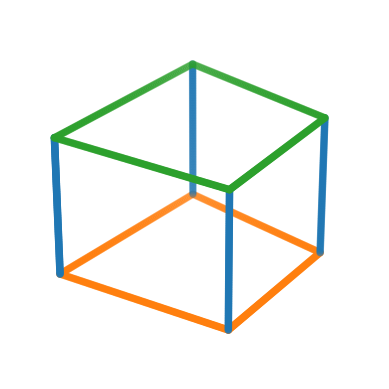

In [78]:
visualizeEdges(new_floor_3D, new_ceil_3D)

Structure room

In [73]:
def getObjectBbox(bbox):
    ini = bbox[0]
    end = bbox[1]
    object_floor = np.array([
        [ini[0], ini[1], ini[2]], 
        [ini[0], end[1], ini[2]], 
        [end[0], end[1], ini[2]], 
        [end[0], ini[1], ini[2]]
    ])
    object_ciel = np.array([
        [ini[0], ini[1], end[2]], 
        [ini[0], end[1], end[2]], 
        [end[0], end[1], end[2]], 
        [end[0], ini[1], end[2]]
    ])
    return object_floor, object_ciel

In [88]:
def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)

def visualizeRoom(room):
    floor_3D = room['floor']
    ceil_3D = room['ceil']
    walls_3D = room['walls']
    objects_3D = room['objects']

    print(type(floor_3D))
    print(floor_3D)

    # sample points to visualize 3D layout
    n = 100

    floor_3D = np.vstack((floor_3D, floor_3D[0,:]))
    ceil_3D = np.vstack((ceil_3D, ceil_3D[0,:]))

    floor_structure = np.array([[np.linspace(floor_3D[p,0],floor_3D[p+1,0],n), \
                    np.linspace(floor_3D[p,1],floor_3D[p+1,1],n), \
                    np.linspace(floor_3D[p,2],floor_3D[p+1,2],n)] for p in range(len(floor_3D)-1)])
    ceil_structure = np.array([[np.linspace(ceil_3D[p,0],ceil_3D[p+1,0],n), \
                    np.linspace(ceil_3D[p,1],ceil_3D[p+1,1],n), \
                    np.linspace(ceil_3D[p,2],ceil_3D[p+1,2],n)] for p in range(len(ceil_3D)-1)])

    # display the 3D layout
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax.scatter(ceil_structure[:,0,:], ceil_structure[:,1,:], ceil_structure[:,2,:])
    #ax.scatter(floor_structure[:,0,:], floor_structure[:,1,:], floor_structure[:,2,:])
    
    #Print Walls
    for wall_3D in walls_3D:
        wall_3D = np.vstack((wall_3D, wall_3D[0,:]))
        wall_structure = np.array([[np.linspace(wall_3D[p,0],wall_3D[p+1,0],n), \
                np.linspace(wall_3D[p,1],wall_3D[p+1,1],n), \
                np.linspace(wall_3D[p,2],wall_3D[p+1,2],n)] for p in range(len(wall_3D)-1)])
        ax.scatter(wall_structure[:,0,:], wall_structure[:,1,:], wall_structure[:,2,:], c = '#000000', s = 0.1)

    #Print Objects
    if len(objects_3D) > 0:
        for object in objects_3D:
            object_floor, object_ciel = getObjectBbox(object['bbox'])
            object_color = Items[object['type']]['color']
            color = rgb_to_hex(object_color[0], object_color[1], object_color[2])
            object_floor = np.vstack((object_floor, object_floor[0,:]))
            object_ciel = np.vstack((object_ciel, object_ciel[0,:]))

            object_floor_structure = np.array([[np.linspace(object_floor[p,0],object_floor[p+1,0],n), \
                            np.linspace(object_floor[p,1],object_floor[p+1,1],n), \
                            np.linspace(object_floor[p,2],object_floor[p+1,2],n)] for p in range(len(object_floor)-1)])
            object_ceil_structure = np.array([[np.linspace(object_ciel[p,0],object_ciel[p+1,0],n), \
                            np.linspace(object_ciel[p,1],object_ciel[p+1,1],n), \
                            np.linspace(object_ciel[p,2],object_ciel[p+1,2],n)] for p in range(len(object_floor)-1)])
            object_walls_structure = np.array([[np.linspace(object_floor[p,0],object_ciel[p,0],n), \
                            np.linspace(object_floor[p,1],object_ciel[p,1],n), \
                            np.linspace(object_floor[p,2],object_ciel[p,2],n)] for p in range(len(object_floor))])

            ax.scatter(object_walls_structure[:,0,:], object_walls_structure[:,1,:], object_walls_structure[:,2,:], c = color, s = 0.1)
            ax.scatter(object_floor_structure[:,0,:], object_floor_structure[:,1,:], object_floor_structure[:,2,:], c = color, s = 0.1)
            ax.scatter(object_ceil_structure[:,0,:], object_ceil_structure[:,1,:], object_ceil_structure[:,2,:], c = color, s = 0.1)

    ax._axis3don = False
    plt.show()

In [118]:
ceilData = np.array([
    [0, 0,  0],
    [0, 4,  0],
    [3, 4,  0],
    [3, 2,  0],
    [5, 2,  0],
    [5, 0,  0]                              
 ])


floorData = np.array([
    [0, 0,  2.5],
    [0, 4,  2.5],
    [3, 4,  2.5],
    [3, 2,  2.5],
    [5, 2,  2.5],
    [5, 0,  2.5]                              
])

wallsData = np.array([
    [
        [0, 0,  0],
        [0, 0,  2.5],
        [0, 4,  2.5],
        [0, 4,  0]
    ],
    [
        [0, 4,  0],
        [0, 4,  2.5],
        [3, 4,  2.5],
        [3, 4,  0]
    ],
    [
        [3, 4,  0],
        [3, 4,  2.5],
        [3, 2,  2.5],
        [3, 2,  0]
    ],
    [
        [3, 2,  0],
        [3, 2,  2.5],
        [5, 2,  2.5],
        [5, 2,  0]
    ],
    [
        [5, 2,  0],
        [5, 2,  2.5],
        [5, 0,  2.5],
        [5, 0,  0]
    ],
    [
        [5, 0,  0],
        [5, 0,  2.5],
        [0, 0,  2.5],
        [0, 0,  0]
    ]
])

objectsData = np.array([
    {
        'type': 1,
        'bbox': [
            [0, 2,  0],
            [1, 4,  1]
        ]
    },
    {
        'type': 3,
        'bbox': [
            [4, 0,  0],
            [5, 2,  1]
        ]
    },
    {
        'type': 5,
        'bbox': [
            [3, -0.2, 1],
            [4, 0,   2]
        ]
    },
        {
        'type': 7,
        'bbox': [
            [3.25, 0.75,  0],
            [3.75, 1.25,  1.2]
        ]
    },
    {
        'type': 9,
        'bbox': [
            [1, 0,  0],
            [3, 1,  1]
        ]
    },
    {
        'type': 10,
        'bbox': [
            [3,     3,  0],
            [3.2,   4,  2]
        ]
    },
        {
        'type': 11,
        'bbox': [
            [0, 0,  0],
            [1, 2,  2]
        ]
    },
    {
        'type': 12,
        'bbox': [
            [1,     3.5,    0],
            [1.5,   4,      1]
        ]
    },
    {
        'type': 14,
        'bbox': [
            [2.5,   2,  0],
            [3,     3,  2]
        ]
    },

])

Room = {
    'ceil' : ceilData,
    'floor' : floorData,
    'walls' : wallsData,
    'objects' : objectsData
}

<class 'numpy.ndarray'>
[[0.  0.  2.5]
 [0.  4.  2.5]
 [3.  4.  2.5]
 [3.  2.  2.5]
 [5.  2.  2.5]
 [5.  0.  2.5]]


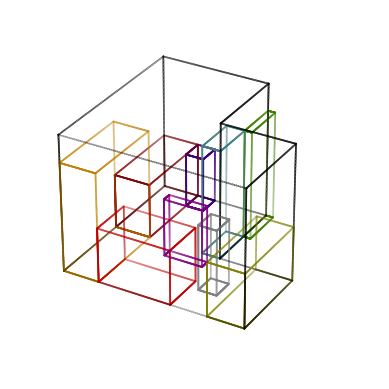

In [126]:
visualizeRoom(Room)